In [1]:
# K-Means
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from sklearn import metrics
from sklearn.datasets import make_blobs


def dist(a, b):
    s = 0.0
    for i in range(len(a)):
        s += (a[i] - b[i])**2
    return s**(1/2)

def drawClusters(points, labels, n_classes, gr_name):
    plt.figure()
    colors = cm.rainbow(np.linspace(0, 1, n_classes))
    j = 0
    step = 0
    if (n_classes % 2 == 0):
       step = 3
    if (n_classes % 3 == 0):
       step = 4
    for i in range(n_classes):
        j = (j + step) % n_classes
        _x = [points[j][0] for j in range(len(points)) if (labels[j] == i)]
        _y = [points[j][1] for j in range(len(points)) if (labels[j] == i)]
        plt.scatter(_x, _y, s = 2, color = colors[j])
    plt.title(gr_name)
    plt.show()

def kMeans(points, n_classes, n_features):
    centres = [random.randint(0, len(points) - 1)]
    for i in range(n_classes - 1):
        mx = -1
        ind = 0
        for j in range(len(points)):
            mn = 1000
            for g in range(len(centres)):
                if (dist(points[centres[g]], points[j]) < mn):
                    mn = dist(points[centres[g]], points[j])
            if (mn > mx):
                mx = mn
                ind = j
        centres.append(ind)
    classes = [0] * len(points)
    new_centres = [0] * n_classes
    f = True
    while (f):
        s = [[0] * n_features for i in range(n_classes)]
        cnt_points = [0] * n_classes
        for i in range(len(points)):
            min_d = 100
            cl = -1
            for j in range(n_classes):
                d = dist(points[i], points[centres[j]])
                if (d < min_d):
                    min_d = d
                    cl = j
            classes[i] = cl
            cnt_points[cl] += 1
            for j in range(n_features):
                s[cl][j] += points[i][j]
        for i in range(n_classes):
            for g in range(n_features):
                s[i][g] /= cnt_points[i]
        for i in range(n_classes):
            min_d = 100
            cl = -1
            for j in range(len(points)):
                d = dist(points[j][0:n_features], s[i])
                if (d < min_d and classes[j] == i):
                    min_d = d
                    cl = j
            new_centres[i] = cl
        f = False
        for i in range(n_classes):
            if (centres[i] != new_centres[i]):
                f = True
                break
        centres = [new_centres[i] for i in range(n_classes)]
    return classes

In [2]:
# AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# Dataset
iris = datasets.load_iris()
data = pd.DataFrame(iris.data,columns = iris.feature_names)

target = iris.target_names
labels = iris.target

#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

#PCA Transformation
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data = principalComponents , columns = ['principal component 1', 'principal component 2','principal component 3'])

datapoints = PCAdf.values
m, f = datapoints.shape
k = 3

def init_medoids(X, k):
    from numpy.random import choice
    from numpy.random import seed
 
    seed(1)
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]

medoids_initial = init_medoids(datapoints, 3)

def compute_d_p(X, medoids, p):
    m = len(X)
    medoids_shape = medoids.shape
    # If a 1-D array is provided, 
    # it will be reshaped to a single row 2-D array
    if len(medoids_shape) == 1: 
        medoids = medoids.reshape((1,len(medoids)))
    k = len(medoids)
    
    S = np.empty((m, k))
    
    for i in range(m):
        d_i = np.linalg.norm(X[i, :] - medoids, ord=p, axis=1)
        S[i, :] = d_i**p

    return S
  
S = compute_d_p(datapoints, medoids_initial, 2)


def assign_labels(S):
    return np.argmin(S, axis=1)
  
labels = assign_labels(S)

def update_medoids(X, medoids, p):
    
    S = compute_d_p(datapoints, medoids, p)
    labels = assign_labels(S)
        
    out_medoids = medoids
                
    for i in set(labels):
        
        avg_dissimilarity = np.sum(compute_d_p(datapoints, medoids[i], p))

        cluster_points = datapoints[labels == i]
        
        for datap in cluster_points:
            new_medoid = datap
            new_dissimilarity= np.sum(compute_d_p(datapoints, datap, p))
            
            if new_dissimilarity < avg_dissimilarity :
                avg_dissimilarity = new_dissimilarity
                
                out_medoids[i] = datap
                
    return out_medoids

def has_converged(old_medoids, medoids):
    return set([tuple(x) for x in old_medoids]) == set([tuple(x) for x in medoids])
  
#Full algorithm
def kmedoids(X, k, p, starting_medoids=None, max_steps=np.inf):
    if starting_medoids is None:
        medoids = init_medoids(X, k)
    else:
        medoids = starting_medoids
        
    converged = False
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        old_medoids = medoids.copy()
        
        S = compute_d_p(X, medoids, p)
        
        labels = assign_labels(S)
        
        medoids = update_medoids(X, medoids, p)
        
        converged = has_converged(old_medoids, medoids)
        i += 1
    return (medoids,labels)

results = kmedoids(datapoints, 3, 2)
final_medoids = results[0]
data['clusters'] = results[1]

#Count
def mark_matches(a, b, exact=False):
    assert a.shape == b.shape
    a_int = a.astype(dtype=int)
    b_int = b.astype(dtype=int)
    all_axes = tuple(range(len(a.shape)))
    assert ((a_int == 0) | (a_int == 1) | (a_int == 2)).all()
    assert ((b_int == 0) | (b_int == 1) | (b_int == 2)).all()
    
    exact_matches = (a_int == b_int)
    if exact:
        return exact_matches

    assert exact == False
    num_exact_matches = np.sum(exact_matches)
    if (2*num_exact_matches) >= np.prod (a.shape):
        return exact_matches
    return exact_matches == False # Invert

def count_matches(a, b, exact=False):
    matches = mark_matches(a, b, exact=exact)
    return np.sum(matches)

In [4]:
def result(X, y, labels):
  print('Estimated number of clusters: %d' % n_clusters)
  print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
  print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
  print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
  print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels, average_method='arithmetic'))
  print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
  print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))

np.random.seed(1)
batch_size = 50
centers = [[1, 1], [0, 0], [-1, -1]] #центры
n_clusters = len(centers)

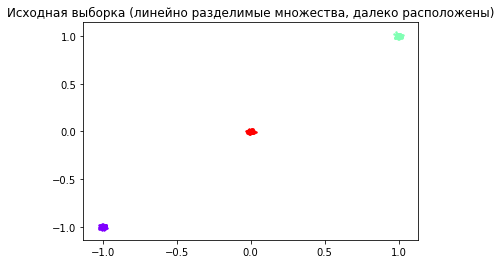

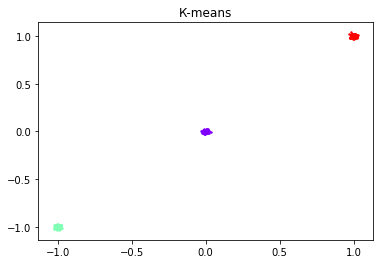

Estimated number of clusters: 3
Homogeneity: 1.000
Completeness: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.987
V-measure: 1.000


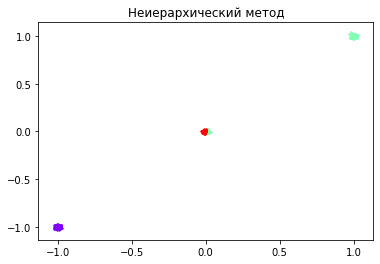

Estimated number of clusters: 3
Homogeneity: 0.687
Completeness: 0.769
Adjusted Rand Index: 0.612
Adjusted Mutual Information: 0.725
Silhouette Coefficient: 0.492
V-measure: 0.725


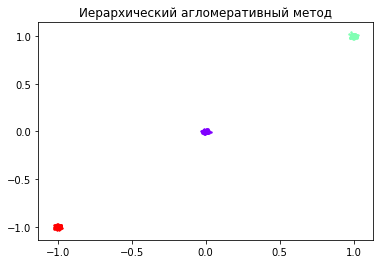

Estimated number of clusters: 3
Homogeneity: 1.000
Completeness: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.987
V-measure: 1.000


In [5]:
samples = 1000 #количество точек
density = 0.01 #расстояние от центра 
k = len(centers) #количество классов
X, y = make_blobs(n_samples=samples, centers=centers, cluster_std=density)
drawClusters(X, y, k, 'Исходная выборка (линейно разделимые множества, далеко расположены)') # рисуем исходную выборку

labels_Kmeans = kMeans(X, n_classes=k, n_features=2)
clustering = AgglomerativeClustering(n_clusters = k).fit(X)
labels_AClusters = clustering.labels_
drawClusters(X, labels_Kmeans, k, 'К-means') # рисуем кластеризацию с помощью k-means
result(X, y, labels_Kmeans)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data = np.column_stack((X, y))
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data = data)
datapoints = PCAdf.values
methods_, labels_Kmedoids = kmedoids(datapoints, k, 2)
drawClusters(X, labels_Kmedoids, k, 'Неиерархический метод') # рисуем кластеризацию с помощью неиерархического метода
result(X, y, labels_Kmedoids)

drawClusters(X, labels_AClusters, k, 'Иерархический агломеративный метод') # рисуем кластеризацию с помощью иерархического агломеративного метода
result(X, y, labels_AClusters)

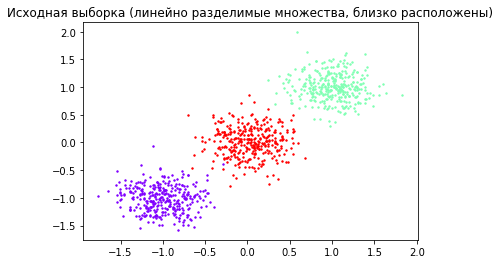

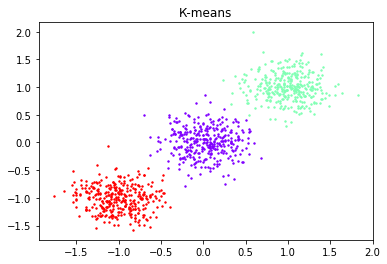

Estimated number of clusters: 3
Homogeneity: 0.981
Completeness: 0.981
Adjusted Rand Index: 0.991
Adjusted Mutual Information: 0.981
Silhouette Coefficient: 0.670
V-measure: 0.981


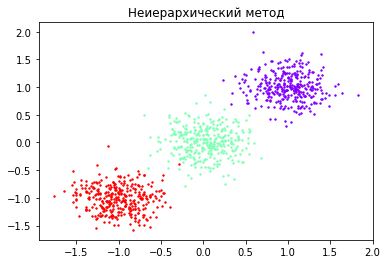

Estimated number of clusters: 3
Homogeneity: 1.000
Completeness: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.668
V-measure: 1.000


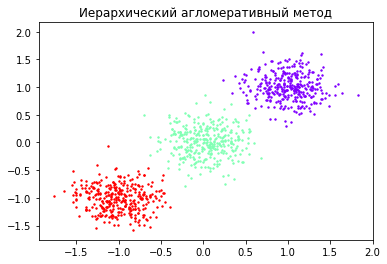

Estimated number of clusters: 3
Homogeneity: 0.981
Completeness: 0.981
Adjusted Rand Index: 0.991
Adjusted Mutual Information: 0.981
Silhouette Coefficient: 0.670
V-measure: 0.981


In [6]:
samples = 1000
density = 0.25
X, y = make_blobs(n_samples=samples, centers=centers, cluster_std=density)
drawClusters(X, y, k, 'Исходная выборка (линейно разделимые множества, близко расположены)') # рисуем исходную выборку

labels_Kmeans = kMeans(X, n_classes=k, n_features=2)
clustering = AgglomerativeClustering(n_clusters = k).fit(X)
labels_AClusters = clustering.labels_
drawClusters(X, labels_Kmeans, k, 'К-means') # рисуем кластеризацию с помощью k-means
result(X, y, labels_Kmeans)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data = np.column_stack((X, y))
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data = data)
datapoints = PCAdf.values
methods_, labels_Kmedoids = kmedoids(datapoints, k, 2)
drawClusters(X, labels_Kmedoids, k, 'Неиерархический метод') # рисуем кластеризацию с помощью неиерархического метода
result(X, y, labels_Kmedoids)

drawClusters(X, labels_AClusters, k, 'Иерархический агломеративный метод') # рисуем кластеризацию с помощью иерархического агломеративного метода
result(X, y, labels_AClusters)

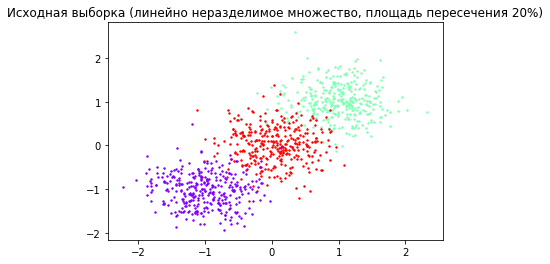

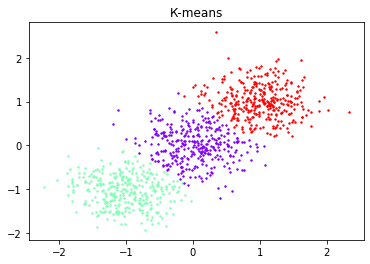

Estimated number of clusters: 3
Homogeneity: 0.799
Completeness: 0.799
Adjusted Rand Index: 0.849
Adjusted Mutual Information: 0.799
Silhouette Coefficient: 0.505
V-measure: 0.799


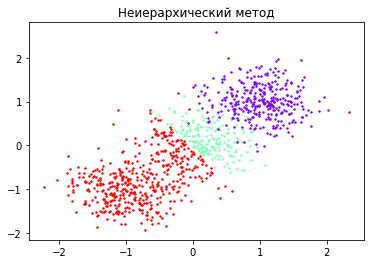

Estimated number of clusters: 3
Homogeneity: 0.721
Completeness: 0.767
Adjusted Rand Index: 0.666
Adjusted Mutual Information: 0.743
Silhouette Coefficient: 0.377
V-measure: 0.743


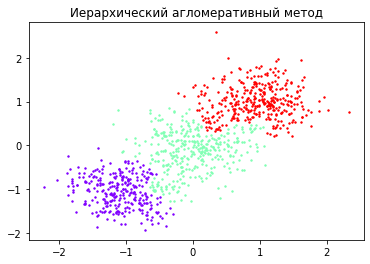

Estimated number of clusters: 3
Homogeneity: 0.691
Completeness: 0.695
Adjusted Rand Index: 0.720
Adjusted Mutual Information: 0.693
Silhouette Coefficient: 0.461
V-measure: 0.693


In [7]:
samples = 1000
density = 0.4
X, y = make_blobs(n_samples=samples, centers=centers, cluster_std=density)
drawClusters(X, y, k, 'Исходная выборка (линейно неразделимое множество, площадь пересечения 20%)') # рисуем исходную выборку

labels_Kmeans = kMeans(X, n_classes=k, n_features=2)
clustering = AgglomerativeClustering(n_clusters = k).fit(X)
labels_AClusters = clustering.labels_
drawClusters(X, labels_Kmeans, k, 'К-means') # рисуем кластеризацию с помощью k-means
result(X, y, labels_Kmeans)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data = np.column_stack((X, y))
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data = data)
datapoints = PCAdf.values
methods_, labels_Kmedoids = kmedoids(datapoints, k, 2)
drawClusters(X, labels_Kmedoids, k, 'Неиерархический метод') # рисуем кластеризацию с помощью неиерархического метода
result(X, y, labels_Kmedoids)

drawClusters(X, labels_AClusters, k, 'Иерархический агломеративный метод') # рисуем кластеризацию с помощью иерархического агломеративного метода
result(X, y, labels_AClusters)


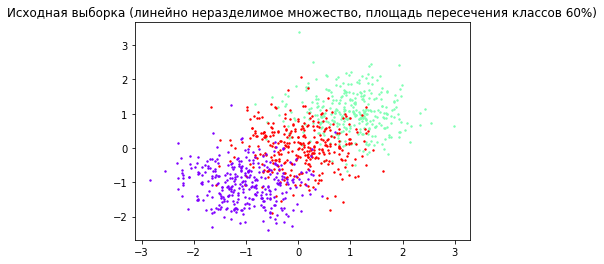

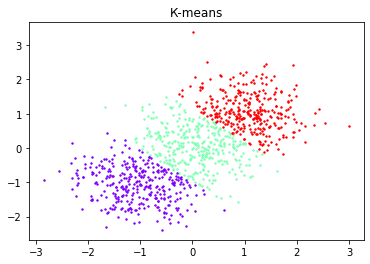

Estimated number of clusters: 3
Homogeneity: 0.545
Completeness: 0.545
Adjusted Rand Index: 0.570
Adjusted Mutual Information: 0.544
Silhouette Coefficient: 0.386
V-measure: 0.545


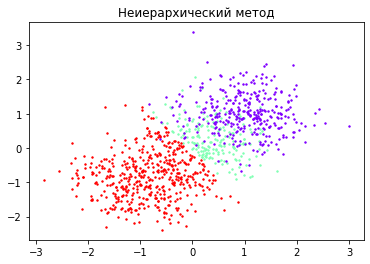

Estimated number of clusters: 3
Homogeneity: 0.720
Completeness: 0.763
Adjusted Rand Index: 0.665
Adjusted Mutual Information: 0.741
Silhouette Coefficient: 0.268
V-measure: 0.741


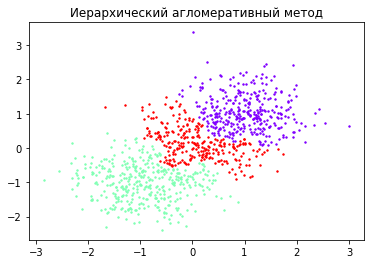

Estimated number of clusters: 3
Homogeneity: 0.536
Completeness: 0.541
Adjusted Rand Index: 0.562
Adjusted Mutual Information: 0.538
Silhouette Coefficient: 0.357
V-measure: 0.539


In [8]:
samples = 1000
density = 0.6
X, y = make_blobs(n_samples=samples, centers=centers, cluster_std=density)
drawClusters(X, y, k, 'Исходная выборка (линейно неразделимое множество, площадь пересечения классов 60%)') # рисуем исходную выборку

labels_Kmeans = kMeans(X, n_classes=k, n_features=2)
clustering = AgglomerativeClustering(n_clusters = k).fit(X)
labels_AClusters = clustering.labels_
drawClusters(X, labels_Kmeans, k, 'К-means') # рисуем кластеризацию с помощью k-means
result(X, y, labels_Kmeans)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data = np.column_stack((X, y))
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data = data)
datapoints = PCAdf.values
methods_, labels_Kmedoids = kmedoids(datapoints, k, 2)
drawClusters(X, labels_Kmedoids, k, 'Неиерархический метод') # рисуем кластеризацию с помощью неиерархического метода
result(X, y, labels_Kmedoids)

drawClusters(X, labels_AClusters, k, 'Иерархический агломеративный метод') # рисуем кластеризацию с помощью иерархического агломеративного метода
result(X, y, labels_AClusters)

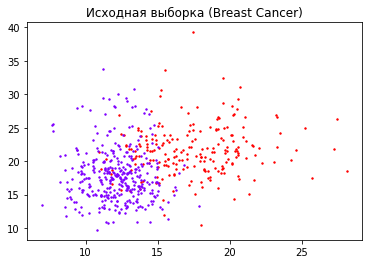

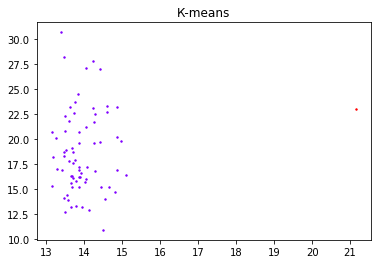

Estimated number of clusters: 3
Homogeneity: 0.034
Completeness: 0.057
Adjusted Rand Index: -0.032
Adjusted Mutual Information: 0.039
Silhouette Coefficient: -0.291
V-measure: 0.042


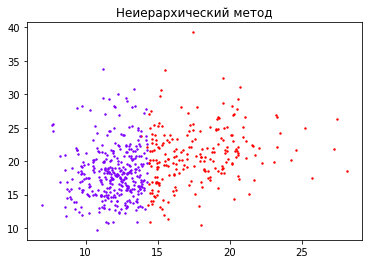

Estimated number of clusters: 3
Homogeneity: 0.416
Completeness: 0.413
Adjusted Rand Index: 0.535
Adjusted Mutual Information: 0.414
Silhouette Coefficient: 0.550
V-measure: 0.415


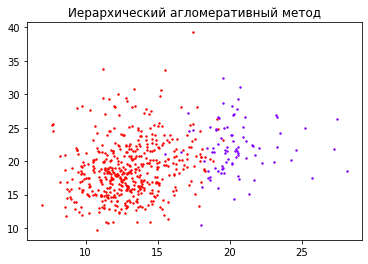

Estimated number of clusters: 3
Homogeneity: 0.262
Completeness: 0.408
Adjusted Rand Index: 0.287
Adjusted Mutual Information: 0.318
Silhouette Coefficient: 0.690
V-measure: 0.319


In [9]:
from sklearn.datasets import load_breast_cancer

dataset1 = load_breast_cancer()
X = dataset1.data
y = dataset1.target
k = 2
drawClusters(X, y, k, 'Исходная выборка (Breast Cancer)') # рисуем исходную выборку

labels_Kmeans = kMeans(X, n_classes=k, n_features=2)
clustering = AgglomerativeClustering(n_clusters = k).fit(X)
labels_AClusters = clustering.labels_
drawClusters(X, labels_Kmeans, k, 'К-means') # рисуем кластеризацию с помощью k-means
result(X, y, labels_Kmeans)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data = np.column_stack((X, y))
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data = data)
datapoints = PCAdf.values
methods_, labels_Kmedoids = kmedoids(datapoints, k, 2)
drawClusters(X, labels_Kmedoids, k, 'Неиерархический метод') # рисуем кластеризацию с помощью неиерархического метода
result(X, y, labels_Kmedoids)

drawClusters(X, labels_AClusters, k, 'Иерархический агломеративный метод') # рисуем кластеризацию с помощью иерархического агломеративного метода
result(X, y, labels_AClusters)

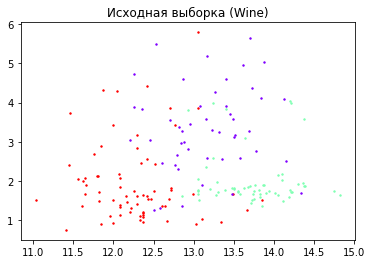

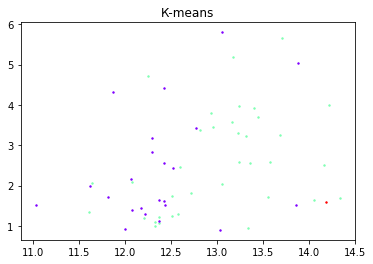

Estimated number of clusters: 3
Homogeneity: 0.133
Completeness: 0.162
Adjusted Rand Index: 0.054
Adjusted Mutual Information: 0.131
Silhouette Coefficient: -0.010
V-measure: 0.146


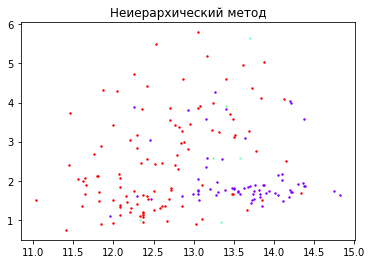

Estimated number of clusters: 3
Homogeneity: 0.403
Completeness: 0.551
Adjusted Rand Index: 0.472
Adjusted Mutual Information: 0.458
Silhouette Coefficient: 0.220
V-measure: 0.465


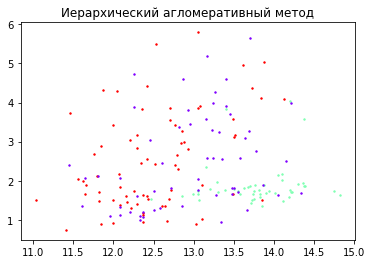

Estimated number of clusters: 3
Homogeneity: 0.416
Completeness: 0.416
Adjusted Rand Index: 0.368
Adjusted Mutual Information: 0.410
Silhouette Coefficient: 0.564
V-measure: 0.416


In [10]:
from sklearn.datasets import load_wine

dataset2 = load_wine()
X = dataset2.data
y = dataset2.target
k = 3
drawClusters(X, y, k, 'Исходная выборка (Wine)') # рисуем исходную выборку

labels_Kmeans = kMeans(X, n_classes=k, n_features=2)
clustering = AgglomerativeClustering(n_clusters = k).fit(X)
labels_AClusters = clustering.labels_
drawClusters(X, labels_Kmeans, k, 'К-means') # рисуем кластеризацию с помощью k-means
result(X, y, labels_Kmeans)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
data = np.column_stack((X, y))
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data = data)
datapoints = PCAdf.values
methods_, labels_Kmedoids = kmedoids(datapoints, k, 2)
drawClusters(X, labels_Kmedoids, k, 'Неиерархический метод') # рисуем кластеризацию с помощью неиерархического метода
result(X, y, labels_Kmedoids)

drawClusters(X, labels_AClusters, k, 'Иерархический агломеративный метод') # рисуем кластеризацию с помощью иерархического агломеративного метода
result(X, y, labels_AClusters)